In [2]:
library(foreign)
library(grf)
library(dplyr)

**Description Data & Jobmarket Program**

The estimation of Treatment Effects **has been a long lasting topic ever after(?)** especially in the area of labor economics. I hereby refer to the discussions of the Lalonde (1986) and Dehejia & Wahba (1998) papers, which have been described in Cunningham (2021). To be in line with the topic of this final project, I reconsider the LaLonde Data Set, which can be downloaded [here](https://users.nber.org/~rdehejia/nswdata.html), and apply the Causal Forest Estimation method in order to check for heterogeneity in treatment effects.

Both papers deal with the effectiveness of the NSW program which "was a temporary employment program designed to help disadvantaged workers lacking basic job skills move into the labor market" where applicants were assigned "to training positions randomly" (LaLonde 1986). However, they only distinguish between female and male treatment effects. That's why I will evaluate the heterogeneity in treatment effects in greater detail.     

**Description of findings by LaLonde and Deijihba**

**Problem (Selection Bias) with previously used methods**

**Advantage of this Matching method compared to Propensity Score Matching**


In [168]:
data <- read.dta("nsw.dta")
head(data)

data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
Lalonde Sample,1,37,11,1,0,1,1,0,9930.0459
Lalonde Sample,1,22,9,0,1,0,1,0,3595.8940
Lalonde Sample,1,30,12,1,0,0,0,0,24909.4492
Lalonde Sample,1,27,11,1,0,0,1,0,7506.1460
Lalonde Sample,1,33,8,1,0,0,1,0,289.7899
Lalonde Sample,1,22,9,1,0,0,1,0,4056.4939


## Causal Forest Estimations

In [169]:
Y <- data$re78
W <- data$treat
X <- data[,-c(1,2,10)]

In [174]:
set.seed(123)

In [175]:
### Untrainted CF
cf_pilot <- causal_forest(X, Y, W , num.trees = 10000)
var_imp <- variable_importance(cf_pilot) 
select_index <- which(var_imp >= median(var_imp))
#cat("The most important Variables are", select_index, "\n")

### Trained CF
cf <- causal_forest(X[, select_index], Y, W,num.trees = 10000)
tau_hat <- predict(cf)$predictions
data["t_hat"] = tau_hat

The Average Treatment Effect estimated by the Causal Forest using 10000 causal trees per forest is 812.7 \\$. Therefore, participants of the jobmarket training program earn on average 812.7 \\$ than people in the control group.

**Comparison to Lalonde** around 880\\$

In [176]:
#### Average Treatment Effect

average_treatment_effect(cf)

estimate  std.err 
812.7380 495.6172

### Check for Heterogeneity (1)

The analysis of treatment effect heterogeneity in observational data follows the Athey & Wager (2019) paper.
A first check for heterogeneity involves the frequencies of the estimated Conditional Average Treatment Effects. The Histogram below shows that there's a very wide span of CATEs, ranging from -1000 \\$ to 3000 \\$, indicating that Treatment Effects might differ across individuals or some covariates. But this first glance can be flawed and Athey et al. (2020) warn, that "if the histogram is spread out, it may be that the forests are simply overfitting and producing very noisy estimates".

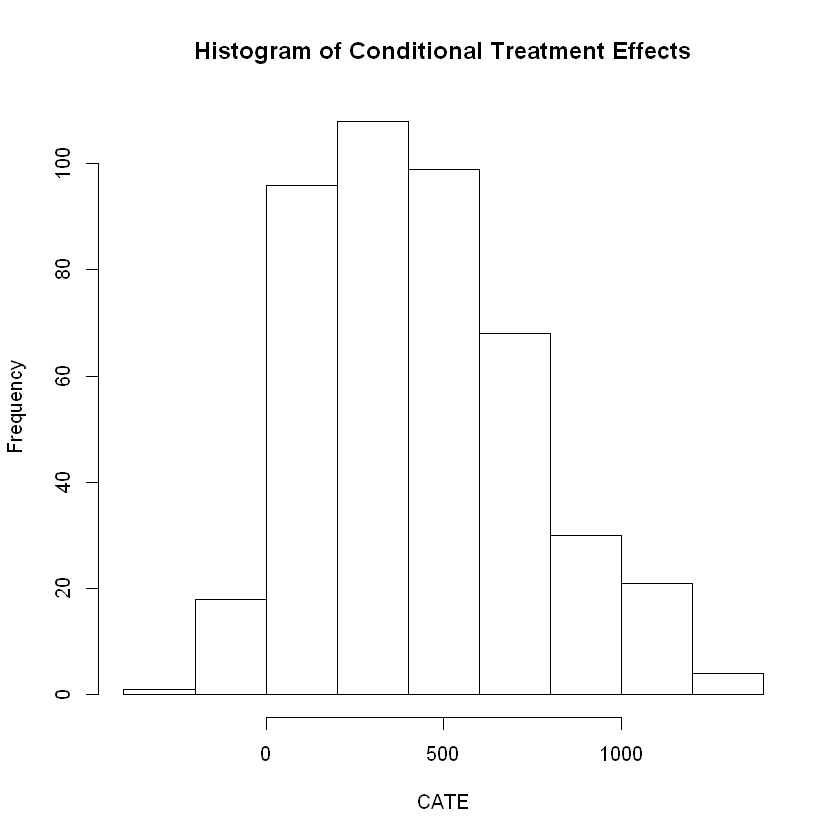

In [146]:
hist(data$t_hat
     ,main = "Histogram of Conditional Treatment Effects"
     ,xlab = "CATE")

### Check for Heterogeneity (2)

A second analysis is to check for heterogeneity across some covariates. In order to obtain variables that have been used quite often to make splits by the causal tree, one can check the variable importance function of the grf package. Here, the variables "age", "education", "married" and "re75" have been used the most by the trees. Therefore, it seems plausible to check for differences in CATE on different levels within these covariates. 

Indeed, the boxplots below show some heterogeneity "when we change a single covariate, while keeping all the other covariates at a some fixed value" (Athey et al. 2020). Especially people above 30 years old and people with a higher degree of education seem to have particular large treatment effects. Furthermore, the treatment effect seems to be negatively correlated with the pretreatment earnings. **This finding seems to have the implication that the jobmarket program seems to effect "the right group of people", those having earned relatively less than other participants. Evaluated at this measure, the program seems to be effective for the right people. (Das ist ja im Grunde interessant: Haben Leute, die es am meisten brauchen, von der Maßnahme profitiert?)** On the other hand, there's only a slight difference between married and unmarried participants. 

In [148]:
#### Variable Importance

colnames(X[,select_index])
select_index

[1] "age"       "education" "re74"      "re75"      "t_hat"

[1] 1 2 7 8 9

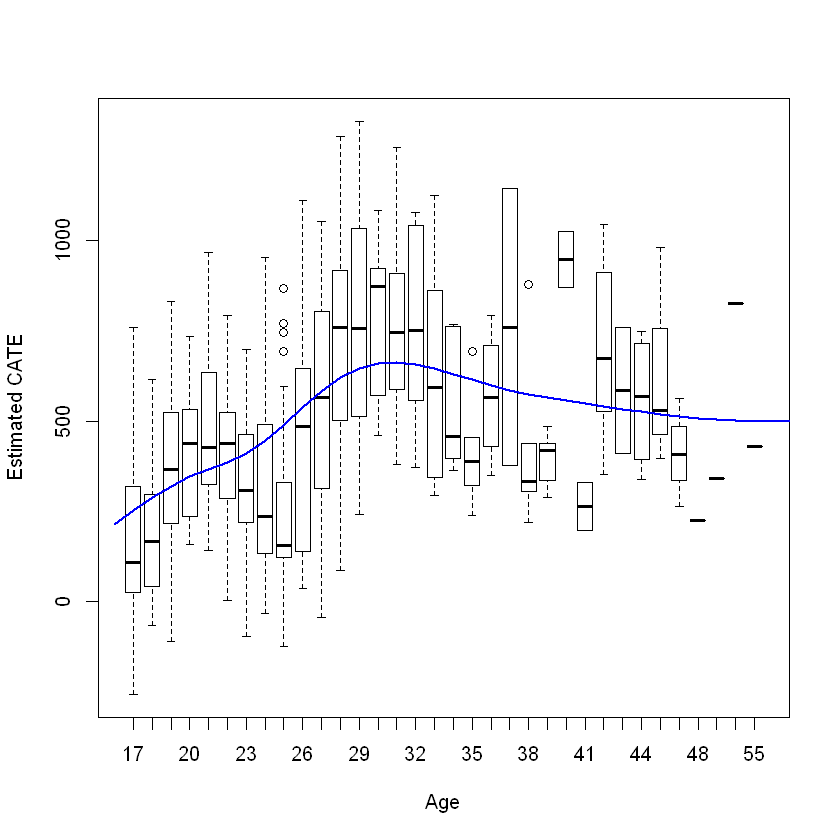

In [149]:
boxplot(data$t_hat ~ X[,1], ylab = "Estimated CATE", xlab = "Age")
lines(smooth.spline(-17 +X[,1], data$t_hat, df = 5), lwd = 2, col = 4)

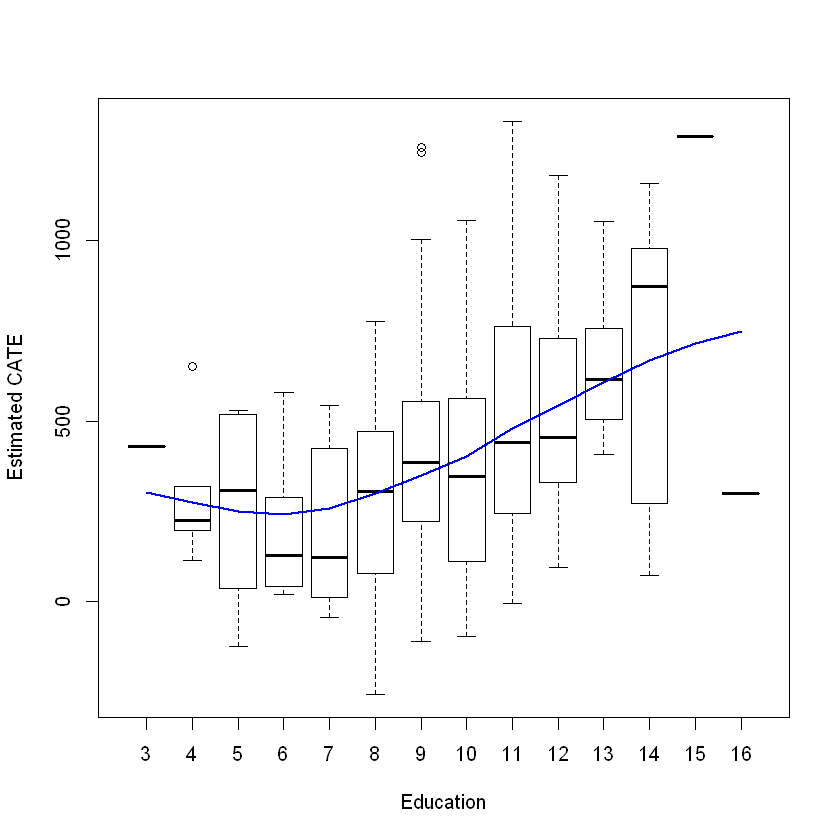

In [150]:
boxplot(data$t_hat ~ X[,2], ylab = "Estimated CATE", xlab = "Education")
lines(smooth.spline(-2 +X[,2], data$t_hat, df = 5), lwd = 2, col = 4)

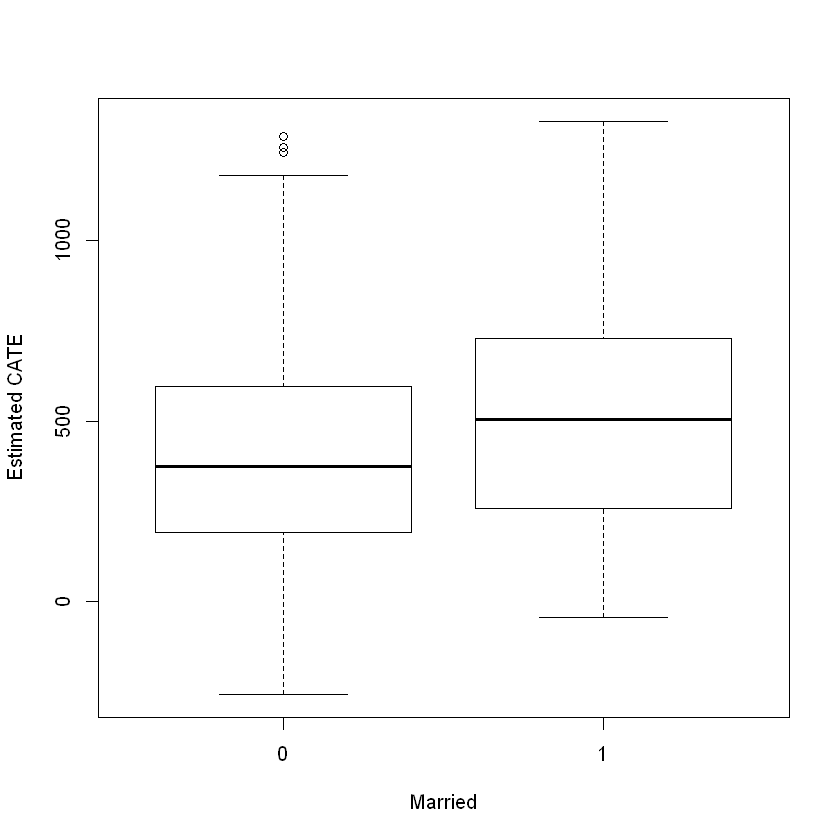

In [156]:
boxplot(data$t_hat ~ X[,5], ylab = "Estimated CATE", xlab = "Married")

In [154]:
data$re75fac <- factor(ntile(data$re75, n=10))

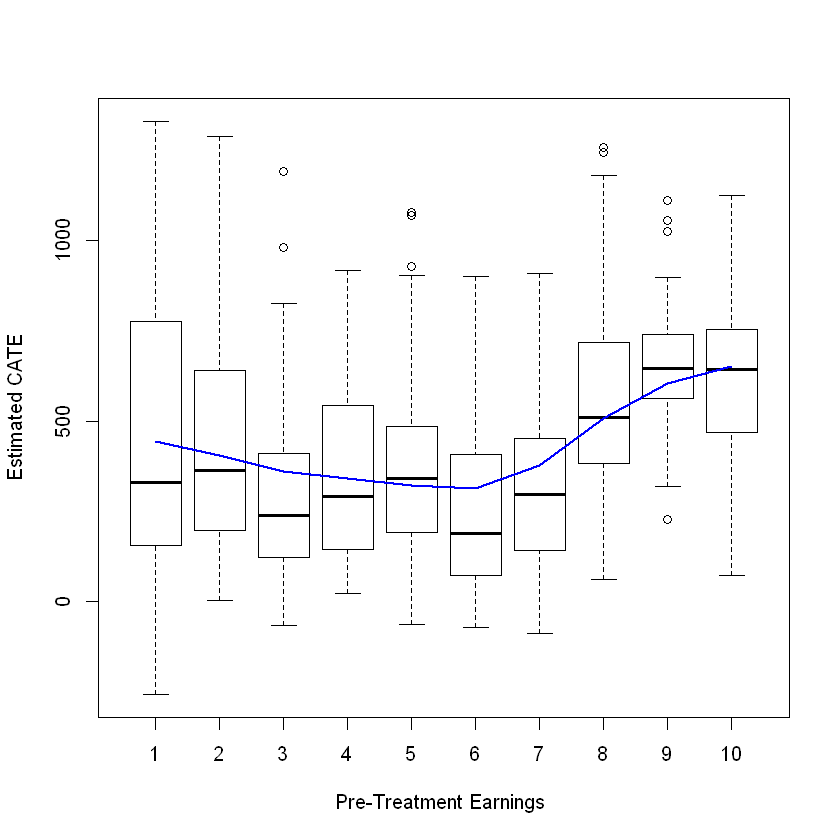

In [155]:
boxplot(data$t_hat ~ data$re75fac, ylab = "Estimated CATE", xlab = "Pre-Treatment Earnings ")
lines(smooth.spline(data$re75fac, data$t_hat, df = 5), lwd = 2, col = 4)